# Merfish to merfish registration with tools


In [1]:
# note for merfish to merfish she used teh same slice I aligned to visium
# and then another one (S2R2)
# S2R3 and S2

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
import glob
import torch

from scipy.stats import rankdata
import nrrd
import time

import tools

import imp
imp.reload(tools)

/nafs/dtward/torch_venv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  app.launch_new_instance()


<module 'tools' from '/ifshome/oamiuwu/STalign/tools.py'>

In [2]:
files = glob.glob('/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/*metadata*.csv.gz')
files.sort()
files

['/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate1_cell_metadata_S1R1.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate2_cell_metadata_S1R2.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice1_Replicate3_cell_metadata_S1R3.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate1_cell_metadata_S2R1.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDrive_1_8-5-2021/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv.gz',
 '/ifshome/dtward/data/merfish/jean_fan_2021/OneDriv

<IPython.core.display.Javascript object>


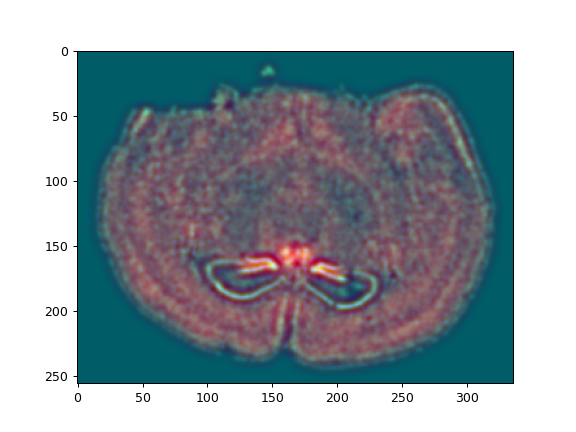

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [3]:

fname = files[-4]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xI = np.array(df['center_x'])
yI = np.array(df['center_y'])
vI = np.array(df['volume'])


imp.reload(tools)
blur = [2.0,1.0,0.5]

draw = 10000
wavelet_magnitude = True
dx = 30.0
use_windowing = True
XI,YI,I,fig = tools.rasterize(xI,yI,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

<IPython.core.display.Javascript object>


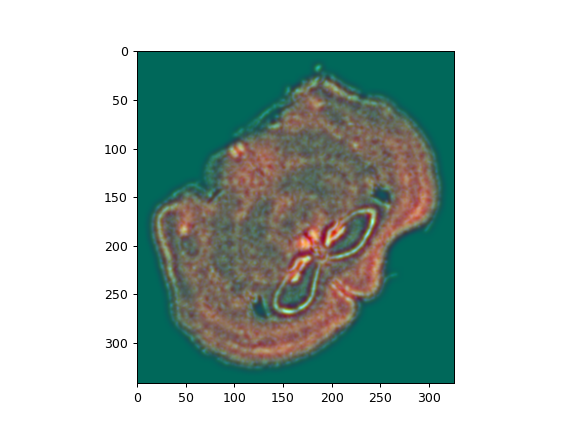

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


In [4]:
fname = files[-5]

names = os.path.splitext(fname)
if names[1] == '.gz':
    names = os.path.splitext(names[0])
outname = names[0] + '_with_structure_id_v02.csv'


df = pd.read_csv(fname.replace('by_gene','metadata'))
xJ = np.array(df['center_x'])
yJ = np.array(df['center_y'])
vJ = np.array(df['volume'])


XJ,YJ,J,fig = tools.rasterize(xJ,yJ,dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

# Declare some points and plot them

<IPython.core.display.Javascript object>


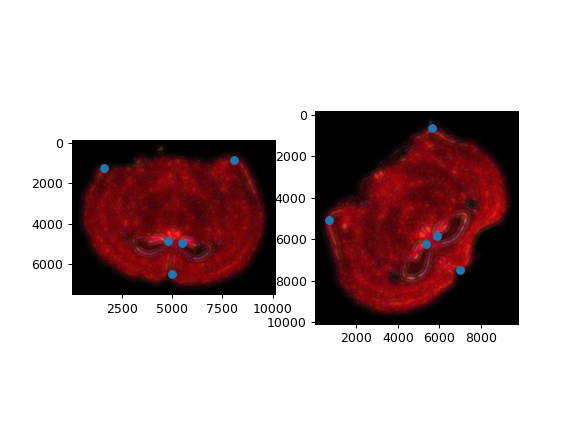

In [5]:
#for each replicate, decide a list of 12 points I can identify reproducably on each image
#say 12 points, 3 training 9 testing
#same points on each replicate
#once have point calculate inital transformation
#choose set of 12 points for a slice, locate points on other replicates
#https://atlas.brain-map.org/

pointsI = None
pointsJ = None
# note points should be in row column not x y, and should be Nx2 for N points
pointsI = np.array([[6500.0,5000.0],[4892.0,4793.0],[4982.0,5508.0],[865.0,8101.0],[1256.0,1618.0]])
pointsJ = np.array([[7500,7000.0],[6238.0,5360.0],[5848.0,5880.0],[640.0,5663.0],[5053.0,675.0]])
extentI = tools.extent_from_x((YI,XI))
extentJ = tools.extent_from_x((YJ,XJ))
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])

<IPython.core.display.Javascript object>


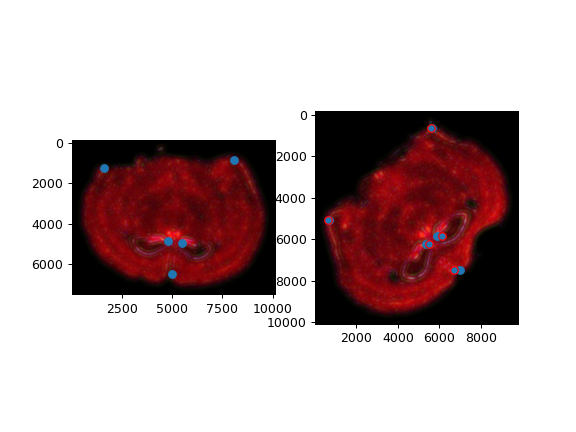

In [6]:
L,T = tools.L_T_from_points(pointsI,pointsJ)    
ApointsI = (L@pointsI.T).T + T
fig,ax = plt.subplots(1,2)
ax[0].imshow((I/np.max(I)).transpose(1,2,0),extent=extentI)
ax[1].imshow((J/np.max(J)).transpose(1,2,0),extent=extentJ)
ax[0].scatter(pointsI[:,1],pointsI[:,0])
ax[1].scatter(pointsJ[:,1],pointsJ[:,0])
ax[1].scatter(ApointsI[:,1],ApointsI[:,0],fc=None,ec='r')

# Run the mapping code

<IPython.core.display.Javascript object>


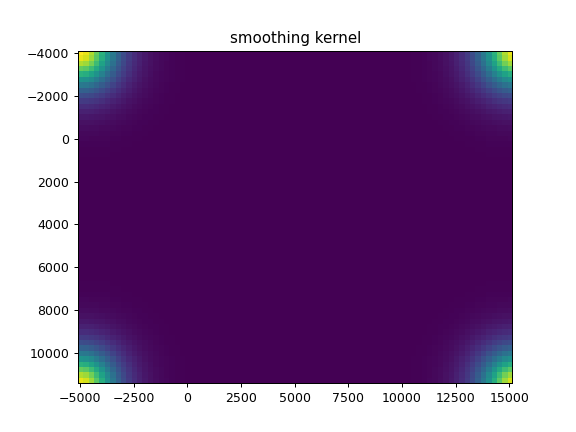

<IPython.core.display.Javascript object>


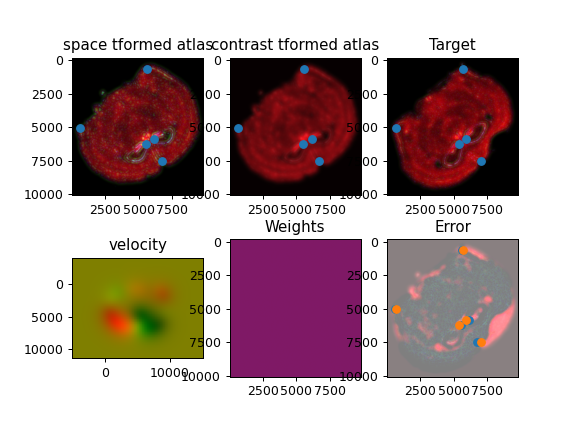

<IPython.core.display.Javascript object>


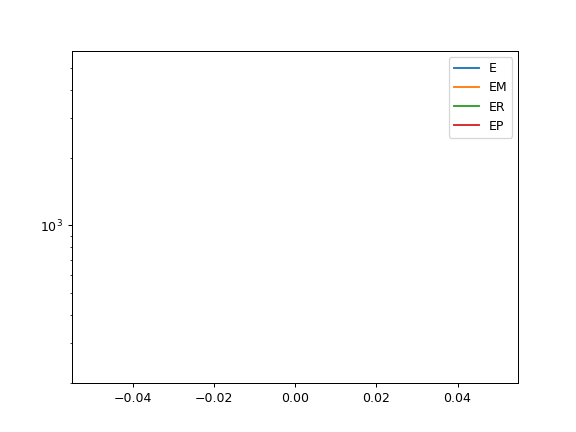

In [19]:
device = 'cpu'
imp.reload(tools)
params = {'L':L,'T':T,
          'pointsI':pointsI,
          'pointsJ':pointsJ,
          'niter':500,
          'device':device,
          }
A,v,xv = tools.LDDMM([YI,XI],I,[YJ,XJ],J,
            **params)

# Test building a transform, forward and backward

In [11]:
imp.reload(tools)
phii = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')

<IPython.core.display.Javascript object>


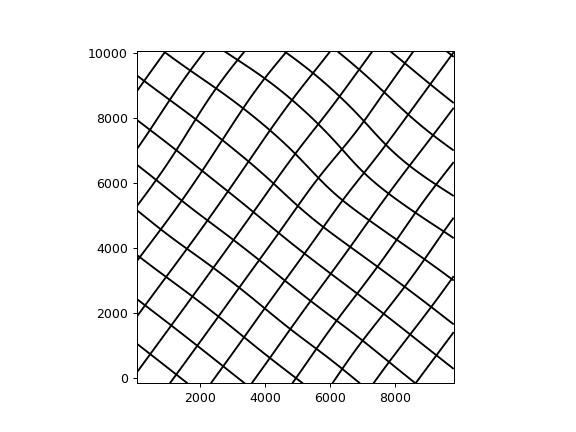

In [12]:
levels = np.arange(-100000,100000,1000)
fig,ax = plt.subplots()
ax.contour(XJ,YJ,phii[...,0],colors='k',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='k',linestyles='-',levels=levels)
ax.set_aspect('equal')

# Apply transform to atlas image

<IPython.core.display.Javascript object>


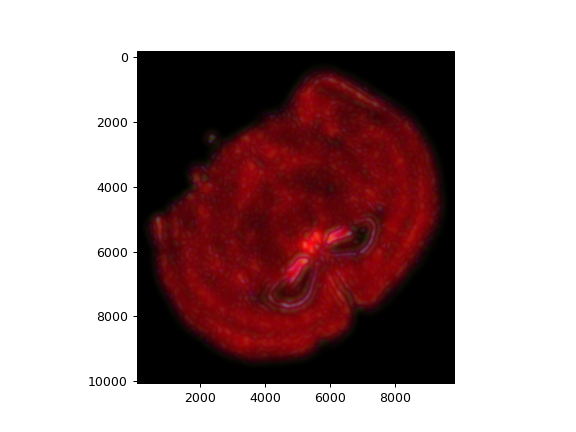

In [14]:
imp.reload(tools)
phiI = tools.transform_image_atlas_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])
fig,ax = plt.subplots()
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)

<IPython.core.display.Javascript object>


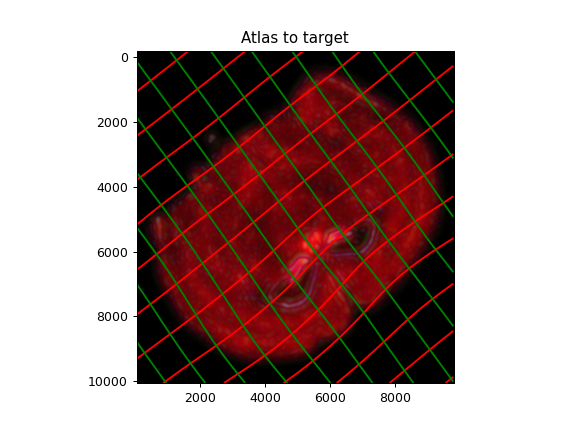

Text(0.5, 1.0, 'Atlas to target')

In [15]:
# build the transform and draw it over
fig,ax = plt.subplots()
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)

phii = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Atlas to target')

<IPython.core.display.Javascript object>


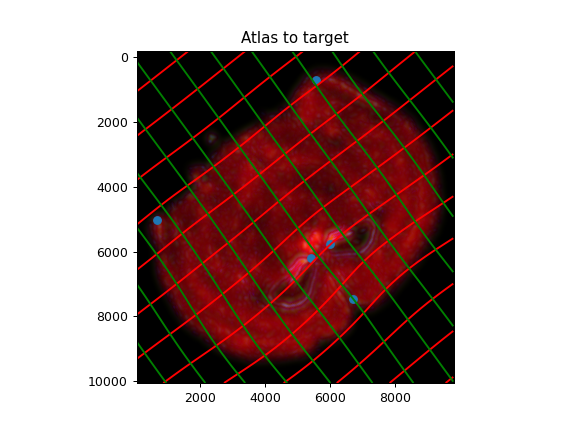

In [18]:
# add points
imp.reload(tools)
phipointsI = tools.transform_points_atlas_to_target(xv,v,A,pointsI)

fig,ax = plt.subplots()
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Atlas to target')

ax.scatter(phipointsI[:,1].detach(),phipointsI[:,0].detach())

# Apply transform to target image

<IPython.core.display.Javascript object>


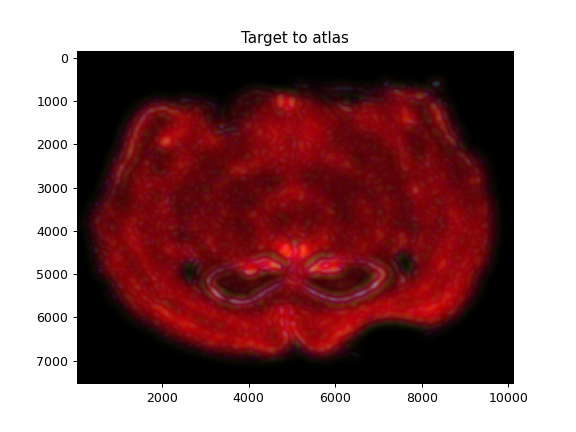

Text(0.5, 1.0, 'Target to atlas')

In [21]:
imp.reload(tools)
phiiJ = tools.transform_image_target_to_atlas(xv,v,A,[YJ,XJ],J,[YI,XI])
fig,ax = plt.subplots()
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.set_title('Target to atlas')

<IPython.core.display.Javascript object>


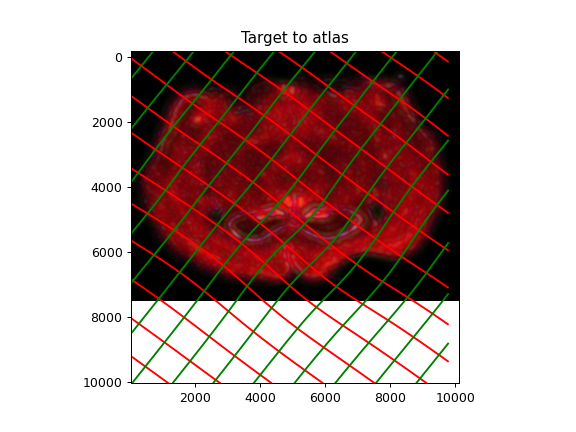

Text(0.5, 1.0, 'Target to atlas')

In [22]:
# build the transform and draw it over
fig,ax = plt.subplots()
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
phi = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='f')
ax.contour(XJ,YJ,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Target to atlas')

<IPython.core.display.Javascript object>


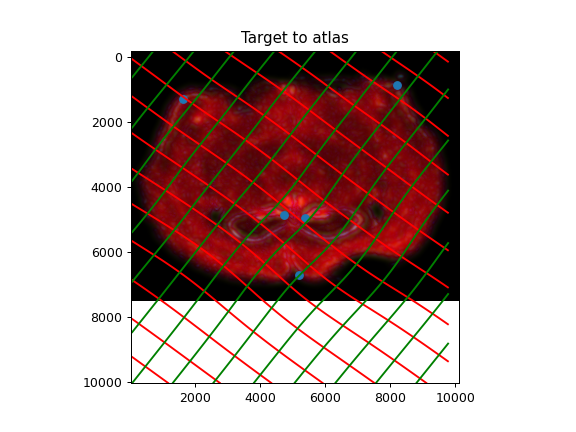

In [23]:
# add points
imp.reload(tools)
phiipointsJ = tools.transform_points_target_to_atlas(xv,v,A,pointsJ)
fig,ax = plt.subplots()
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
phi = tools.build_transform(xv,v,A,XJ=[YJ,XJ],direction='f')
ax.contour(XJ,YJ,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('Target to atlas')
ax.scatter(phiipointsJ[:,1].detach(),phiipointsJ[:,0].detach())

# Transform individual cells

<IPython.core.display.Javascript object>


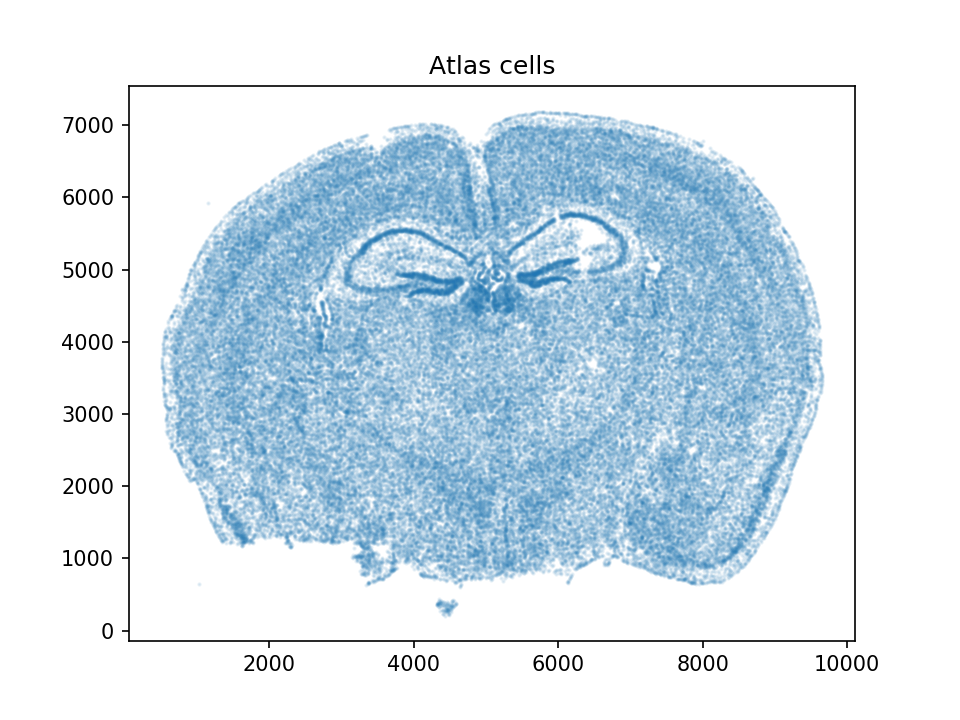

Text(0.5, 1.0, 'Atlas cells')

In [27]:
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1)
ax.set_aspect('equal')
ax.set_title('Atlas cells')

<IPython.core.display.Javascript object>


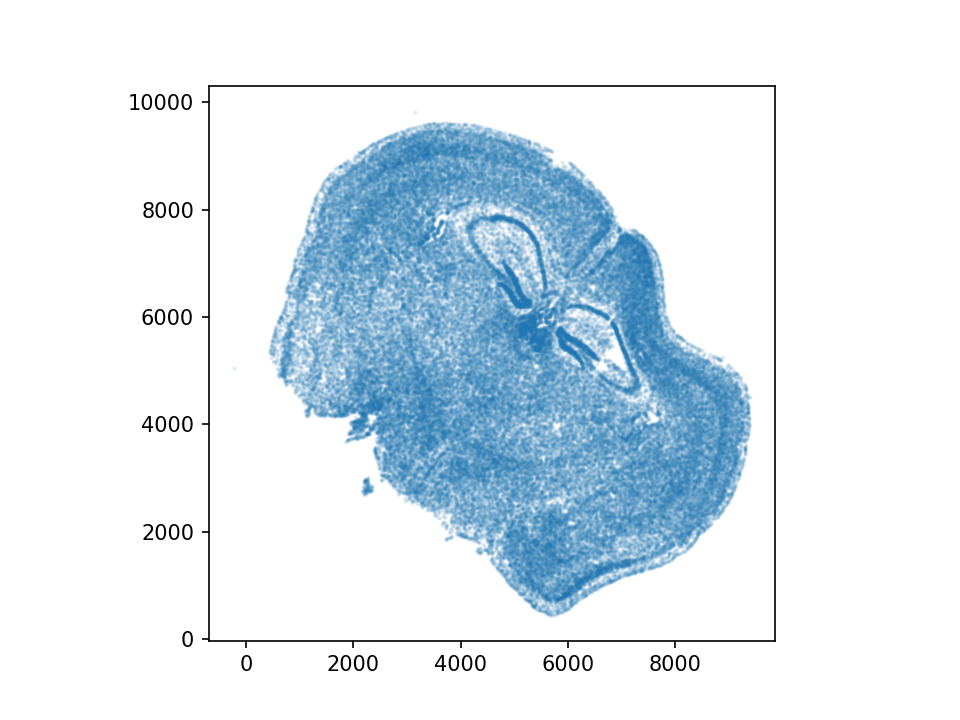

In [28]:
pointsIt = tools.transform_points_atlas_to_target(xv,v,A,np.stack([yI,xI],-1))
fig,ax = plt.subplots()
ax.scatter(pointsIt[:,1],pointsIt[:,0],s=1,alpha=0.1)
ax.set_aspect('equal')
ax.set_title('Transformed atlas cells')

/home/dtward/Documents/UCLA/analyze_merfish/spatial_transcriptomics_registration/tools.py:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if draw: fig,ax = plt.subplots()


<IPython.core.display.Javascript object>


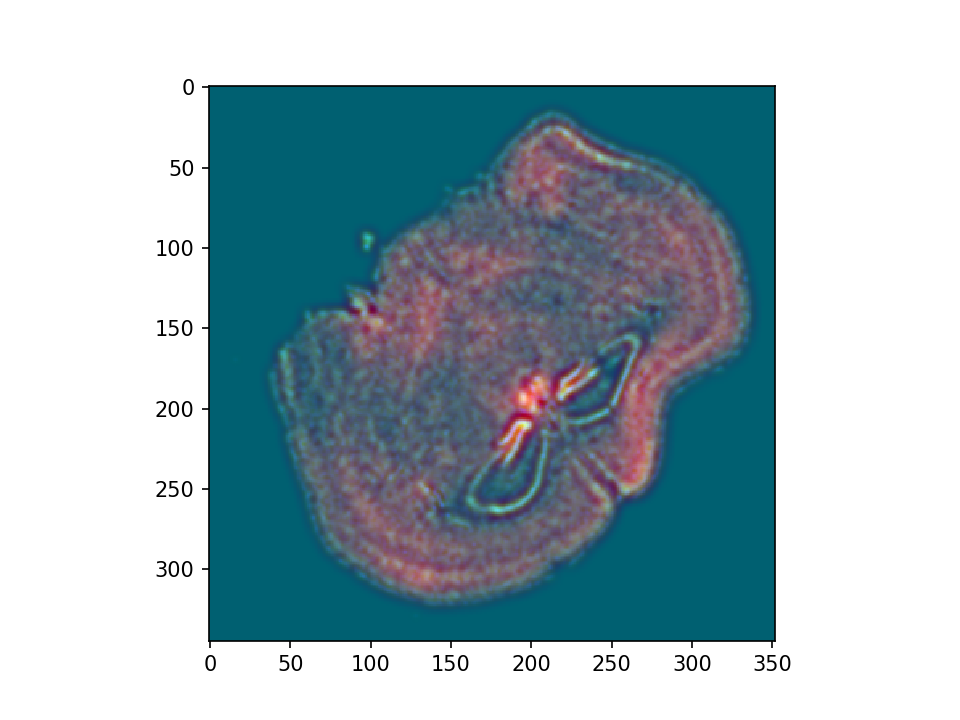

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [46]:
# rasterize them
_,_,phiI_,_ = tools.rasterize(np.array(pointsIt[:,1]),np.array(pointsIt[:,0]),dx=dx,blur=blur,draw=draw, wavelet_magnitude=wavelet_magnitude, use_windowing=use_windowing)

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


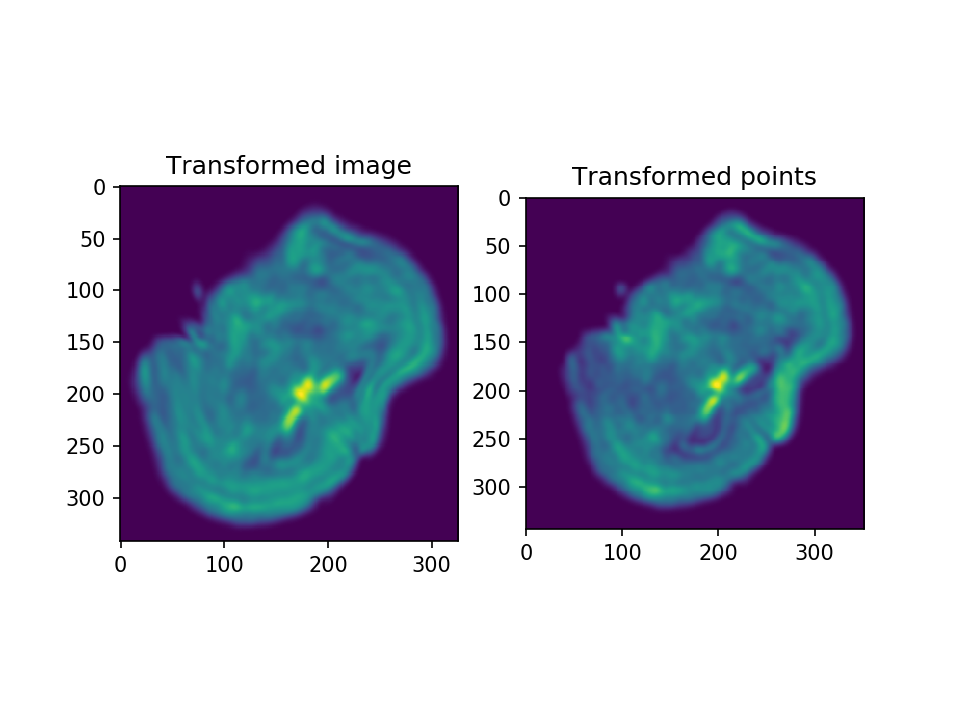

Text(0.5, 1.0, 'Transformed points')

In [51]:
fig,ax = plt.subplots(1,2)
h = ax[0].imshow(phiI[0])
ax[0].set_title('Transformed image')
clim = h.get_clim()
ax[1].imshow(phiI_[0],clim=clim)
ax[1].set_title('Transformed points')

# Manuscript methods details

1. Merfish to merfish alignment
  1. Overview of what we did in our experiment (annotate points, initialize, then optimize)
  1. rasterization (versus points themselves, varifold method, comuptational efficiency, O(N^2) where N is number of points complexity with points, whereas if we rasterize we have MlogM where M is number of pixels (fourier based complexity) )
  1. LDDMM summary (type of transformation)
  1. Objective function we are minimizing
  1. Software tools (implementation, gradient methods, cpu/gpu, etc.)

1. Merfish to visium
  1. Same as point 1 above.

1. Allen CCF to Merfish
  1. summarize experiment
  1. TODO, rebuild these tools into the repo.
  1. describe 3D to 2D differences. e.g. structures could appear or dissapear if they translate in and out of plane.
  1. method differences, rasterize the 2D images, and work with the 3D Nissl atlas.  Estimate a fully 3D transformation.  This will differ from identity near our slice, but be close to identity far away.

In [ ]:
# How necessary is the 2D to 3D, versus picking a coronal slice and doing 2D to 2D
# recall there were some issues with bilateral symmetry
# We can chose a coronal slice and use exactly the same tools
# Or we can add 3D transformations
# Daniel change language to SOURCE and TARGET
# The source gets deformed based on the objective function we are minimizing
# NOT based on how we are going to use it

Objective function we minimize to match $I$ to $J$ with transform $\varphi$.  Regularizatoin plus a dissimilarity term:
$R(\varphi) + D(\varphi\cdot I,J)$

In our case $R$ is a special thing associated with LDDMM, which is a penalty on the size and the non-smoothness of a velocity field.

And in our case the dissimilarity term is, like weighted sum of squared error
\begin{align}
\int |I(\varphi^{-1}(x))  - J(x) |^2 W(x) dx
\end{align}


We actually do this
\begin{align}
\arg \min_c \int |f_c(I(\varphi^{-1}(x)))  - J(x) |^2 W(x) dx
\end{align}

Where $f$ is a function that transforms the contrast in $I$ to match that in $J$, using some unknown parameters $c$.  Usually $f$ is a polynomial of the form $f(I) = c_0 + c_1I + c_2 I^2$.


TODO, mension explicitly what is the W and what would happen if it is not there (artifacts and missing tissue)
mention explicitly the f and what would happen if it is not there (e.g. unknown gain and bias)


The group action of $\varphi$ on $I$ is written as $\varphi \cdot I$.

If we write $\varphi \cdot I \doteq I \circ \varphi^{-1}$.  This is called a varifold action (or an image action).

If we transformed the points directly and then rasterized we would get $\varphi \cdot I \doteq |D\varphi^{-1}| I \circ \varphi^{-1}$